# import and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
#annots = loadmat('C:\\Users\\llinc\\GitHub\\retina_personal\\0406\\merge\\merge_0224_HMM_RL_G2.5_5min_Q100_6.5mW.mat')
%matplotlib inline

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [3]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt


        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [4]:
def Spike_Time_Generater(rdt, dt, Garmma=1):
    rdt = rdt*Garmma
    Spike_time = []
    
    counter = 0
    post_remainer_c = 0
    p = 1
    while True:
        the_random_number = 1-np.random.rand()
        while (the_random_number < p and counter < len(rdt)):
            p *= np.exp(-rdt[counter])
            counter += 1
        if counter >= len(rdt):
            break
        remainer_c = -np.log(p/the_random_number)/rdt[counter-1]
#         if remainer_c>=1 or remainer_c<=0:
#             print('shit!')
        Spike_time.append(dt*(counter-remainer_c))
        p = np.exp(-remainer_c*rdt[counter-1])
    return Spike_time[::Garmma]

# activation function
def NL(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

# chose file

In [5]:
# exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0503'
# G = 4.5
# annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G'+str(G)+'_5min_Q100_6.5mW_1Hz.mat')

# exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0729'
# Fc = 8
# annots = loadmat(exp_folder+'\\merge\\'+'merge_0727_OUsmooth_Bright_UL_DR_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz.mat')

exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408'
Fc_list = [2,4,7,10]
annots_list = []
for Fc in Fc_list:
    annots_list.append(loadmat(exp_folder+'\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2'))

In [6]:
dt = 0.01
sampling_rate = 20000
x_list, v_list, t_cor_list, T_list = [], [], [], []
for annots in annots_list:
    TimeStamps =np.round(np.squeeze(annots['TimeStamps']))
    TimeStamps = TimeStamps.astype(int)
    x = annots['a_data'][0, TimeStamps[0]*sampling_rate:TimeStamps[1]*sampling_rate+1]
    x = x[::int(sampling_rate*dt)]
    x = x.astype(float)
    x = (x -np.mean(x))/np.std(x)
    T = np.arange(1,len(x)+1)*dt
    v = ndimage.gaussian_filter1d(x, sigma=5, order=1, mode='reflect') / dt
    
    x_list.append(x.copy())
    v_list.append(v.copy())
    T_list.append(T.copy())
    x_cor = np.correlate(x, x, "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T[:len(x_cor)]-dt*3/2)
    t_cor_list.append(np.interp(0.5*max(x_cor),  x_cor, Taxis))

# Set $\lambda$s

## ((1-$\lambda$)*x+$\lambda$*v) to (x-$\xi$x$_{-1}$)

Text(0, 0.5, '$\\xi$')

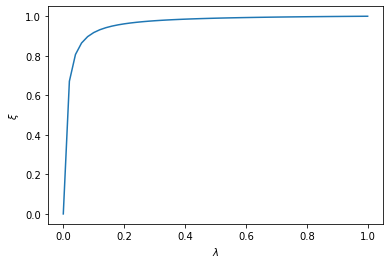

In [9]:
# Lambdas = np.hstack((np.arange(0,100,20), np.arange(100,1000,100)))
Lambdas =  np.append(np.arange(0,1.0,0.02),1.0)
xis = Lambdas/dt/(1+Lambdas*(-1+1/dt))
plt.plot(Lambdas, xis)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\xi$')

In [13]:
xis

array([0.        , 0.67114094, 0.80645161, 0.86455331, 0.89686099,
       0.91743119, 0.93167702, 0.94212651, 0.95011876, 0.95642933,
       0.96153846, 0.96575944, 0.96930533, 0.9723261 , 0.97493036,
       0.9771987 , 0.97919217, 0.98095788, 0.98253275, 0.98394614,
       0.98522167, 0.98637858, 0.98743268, 0.98839708, 0.98928277,
       0.99009901, 0.99085366, 0.99155343, 0.99220411, 0.99281068,
       0.99337748, 0.9939083 , 0.99440646, 0.99487489, 0.99531616,
       0.99573257, 0.99612618, 0.99649879, 0.99685205, 0.99718742,
       0.99750623, 0.99780969, 0.99809886, 0.99837474, 0.99863822,
       0.99889012, 0.99913119, 0.99936211, 0.99958351, 0.99979596,
       1.        ])

In [10]:
##response
# Model one: simple estimation
window = [-1,1] # second
Ux_peaktime_list =[]
Uv_peaktime_list = []
Syn_peaktime_list = []
Rdn_peaktime_list = []
Ux_peakH_list =[]
Uv_peakH_list = []
Syn_peakH_list = []
Rdn_peakH_list = []

MIx_peakH_list = []
MIv_peakH_list = []
MIxv_peakH_list = []

for i in range(len(annots_list)):
    Ux_peaktime =[]
    Uv_peaktime = []
    Syn_peaktime = []
    Rdn_peaktime = []
    Ux_peakH =[]
    Uv_peakH = []
    Syn_peakH = []
    Rdn_peakH = []

    MIx_peakH = []
    MIv_peakH = []
    MIxv_peakH = []

    x = x_list[i]
    v = v_list[i]
    for xi in xis:
        r = x-xi*np.append(0,x[:-1])
        #assign states
        r = NL(np.mean(r)-r, 0)
        ratio = sum(r)/T_list[i][-1]/12
        FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
        rstate, _ = np.histogram(FakeSpike, np.append(0,T_list[i]))
        #rstate = np.random.poisson(rstate)
        rstate = rstate.astype(int)
        xstate,edge = EqualState(x, 6)
        vstate,edge = EqualState(v, 6)
        #calculate information
        timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)
        Ux = Information[('Beer','UIx')]
        Uv = Information[('Beer','UIv')]
        Syner = Information[('Beer','Syn')]
        Redun = Information[('Beer','Red')]
        #find peak
        Ux_peaktime.append( timeshift[int(np.mean(np.where(Ux == max(Ux))))])
        Uv_peaktime.append( timeshift[int(np.mean(np.where(Uv == max(Uv))))])
        Syn_peaktime.append( timeshift[int(np.mean(np.where(Syner == max(Syner))))])
        Rdn_peaktime.append( timeshift[int(np.mean(np.where(Redun == max(Redun))))])
        Ux_peakH.append( max(Ux))
        Uv_peakH.append( max(Uv))
        Syn_peakH.append( max(Syner))
        Rdn_peakH.append( max(Redun))
        MIx_peakH.append( max(Ux+Redun))
        MIv_peakH.append( max(Uv+Redun))
        MIxv_peakH.append( max(Ux+Uv+Redun+Syner))
        
    Ux_peaktime_list.append(np.array(Ux_peaktime).copy())
    Uv_peaktime_list.append(np.array(Uv_peaktime).copy())
    Syn_peaktime_list.append(np.array(Syn_peaktime).copy())
    Rdn_peaktime_list.append(np.array(Rdn_peaktime).copy())
    Ux_peakH_list.append(np.array(Ux_peakH).copy())
    Uv_peakH_list.append(np.array(Uv_peakH).copy())
    Syn_peakH_list.append(np.array(Syn_peakH).copy())
    Rdn_peakH_list.append(np.array(Rdn_peakH).copy())

    MIx_peakH_list.append(np.array(MIx_peakH).copy())
    MIv_peakH_list.append(np.array(MIv_peakH).copy())

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered i

# Plot and Save

In [11]:
XOsave = 0
save_folder = 'C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\4PID_paper\\lambda vs. PI\\'
# save_folder = 'C:\\Users\\llinc\\GitHub\\python code\\4PID_paper\\lambda vs. PI\\'
name = 'WF_PeakHeights_Fc='+str(Fc)

## different Fc (Peak height & time)

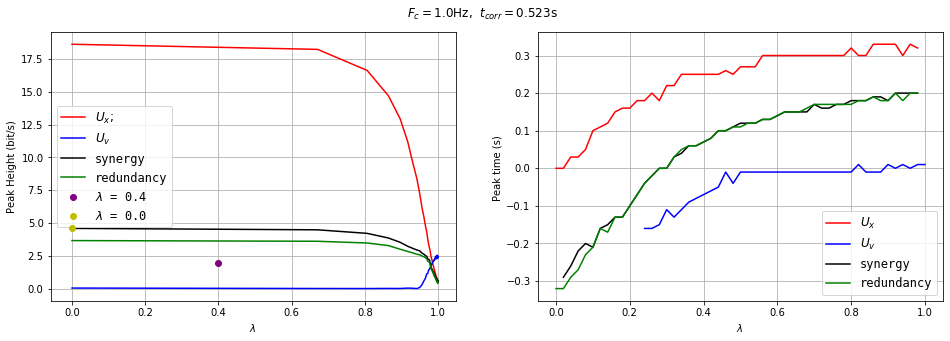

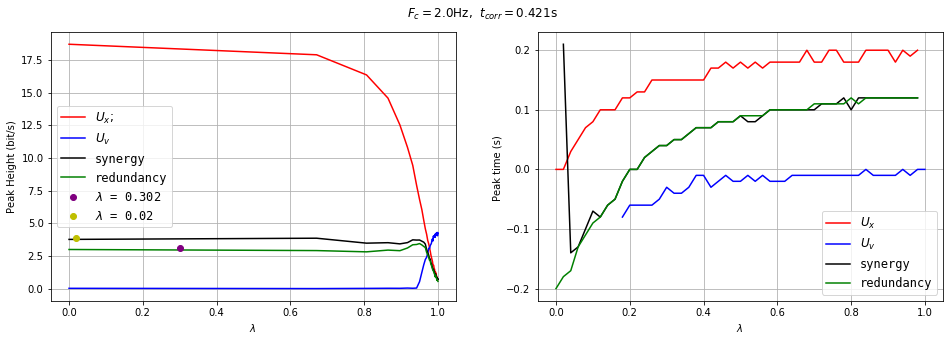

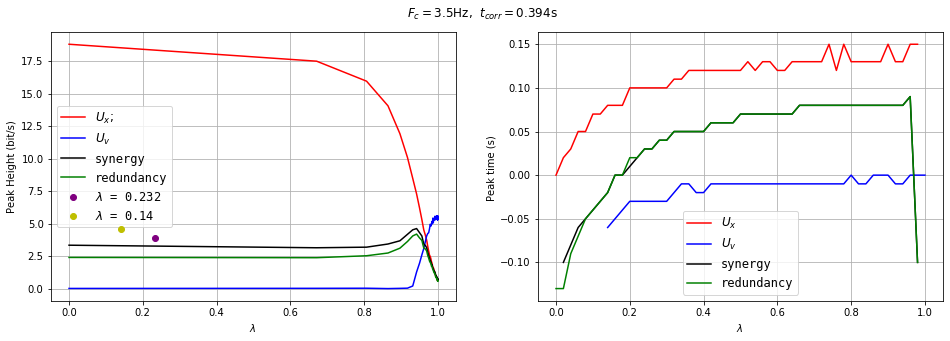

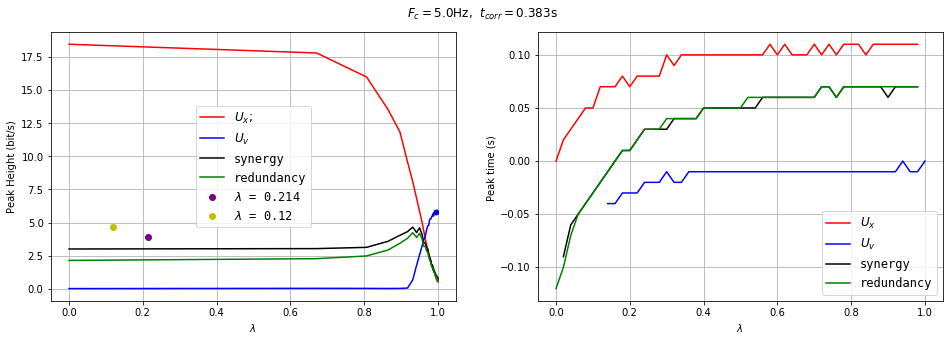

In [12]:
fig_list = []
for i in range(len(annots_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    fig.set_size_inches(16, 4*(np.sqrt(5)-1))
    fig.suptitle(r'$F_c = $'+ str(Fc_list[i]/2)+'Hz,  '+r'$t_{corr}=$'+str(round(t_cor_list[i],3))+'s',y =0.95)
    fig_list.append(fig)
    xvMeatingTime = np.interp(1,  Uv_peakH_list[i]/Ux_peakH_list[i], Lambdas)
    xvMeatingHeight = np.interp(xvMeatingTime,  Lambdas, Ux_peakH_list[i])
    ax2.plot(xis,Ux_peakH_list[i], 'r-')
    ax2.plot(xis,Uv_peakH_list[i], 'b-')
    ax2.plot(xis,Syn_peakH_list[i], 'k-')
    ax2.plot(xis,Rdn_peakH_list[i], 'g-')
    ax2.scatter(xvMeatingTime, xvMeatingHeight, c = 'purple',zorder = 10)
    TurningTime = np.interp(np.where(Syn_peakH_list[i] == max(Syn_peakH_list[i]))[0][0],  np.arange(len(Lambdas)), Lambdas)
    ax2.scatter(TurningTime , max(Syn_peakH_list[i]), c = 'y',zorder = 10)
    ax2.set_xlabel(r'$\lambda $ ')
    ax2.set_ylabel(r'Peak Height (bit/s)')
    ax2.grid(True)
    ax2.legend((r'$U_x;$', r'$U_v$', 'synergy', 'redundancy', '$\lambda$ = '+str(round(xvMeatingTime,3))+'', '$\lambda$ = '+str(round(TurningTime,3))+''), loc='best', prop={'size': 'large', 'family': 'monospace'})
    
    
#     ndimage.gaussian_filter1d(x, sigma=5, order=1, mode='reflect')
    usefullI = np.where(Ux_peakH_list[i]>=8)
    usefullI =range(50)
    ax3.plot(Lambdas[usefullI],Ux_peaktime_list[i][usefullI], 'r-')
    usefullI = np.where(Uv_peakH_list[i]>=1)
    ax3.plot(Lambdas[usefullI],Uv_peaktime_list[i][usefullI], 'b-')
    usefullI = np.where(Syn_peakH_list[i]>=8)
    usefullI =np.arange(1,50)
    ax3.plot(Lambdas[usefullI],Syn_peaktime_list[i][usefullI], 'k-')
    usefullI = np.where(Rdn_peakH_list[i]>=1)
    usefullI =np.arange(0,50)
    ax3.plot(Lambdas[usefullI],Rdn_peaktime_list[i][usefullI], 'g-')
    
#     zeroTime = np.interp(0, Syn_peaktime_list[i][1:], Lambdas[1:])
#     ax3.scatter(zeroTime, 0, c='y')
    ax3.set_xlabel(r'$\lambda$ ')
    ax3.set_ylabel('Peak time (s) ')
    ax3.legend( (r'$U_x$ ; '+str(round(Ux_peaktime_list[i][-1],3)), r'$U_v$ ; '+str(round(Uv_peaktime_list[i][-1],3)), 'synergy; '+str(round(Syn_peaktime[-1],3)), 'redundancy; '+str(round(Rdn_peaktime_list[i][-1],3))), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax3.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax3.grid(True)

In [13]:
if XOsave:
    for i in range(len(annots_list)):
        name = 'PeakHeightsnTime_Fc='+str(Fc_list[i])
        fig_list[i].savefig(save_folder+name+'.tif')

## different Fc (Ratio)

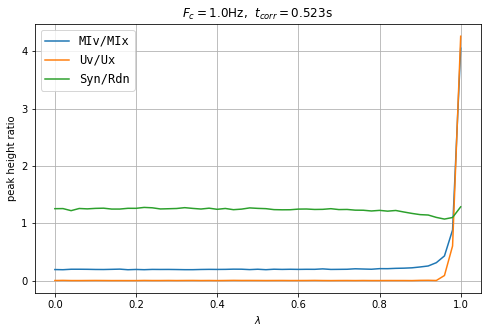

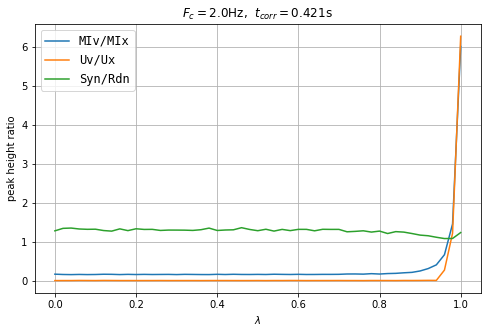

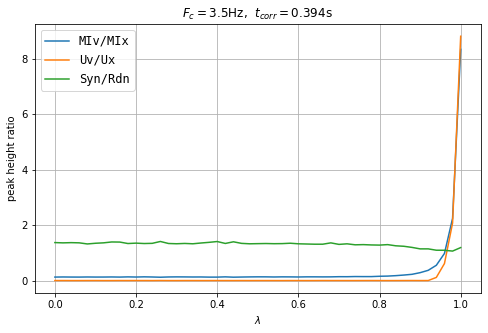

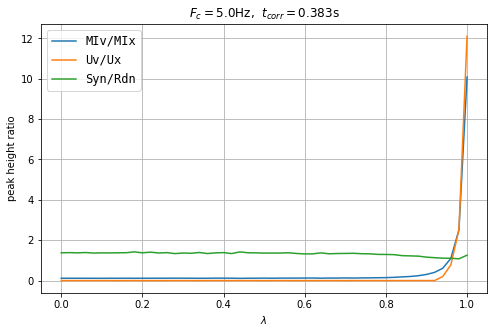

In [14]:
for i in range(len(annots_list)):
    plt.plot(Lambdas,MIv_peakH_list[i]/MIx_peakH_list[i])
    plt.plot(Lambdas,Uv_peakH_list[i]/Ux_peakH_list[i])
    plt.plot(Lambdas,Syn_peakH_list[i]/Rdn_peakH_list[i])
    plt.gcf().set_size_inches(8, 4*(np.sqrt(5)-1))
    plt.xlabel(r'$\lambda$ ')
    plt.ylabel('peak height ratio')
    plt.title(r'$F_c = $'+ str(Fc_list[i]/2)+'Hz,  '+r'$t_{corr}=$'+str(round(t_cor_list[i],3))+'s')
    plt.legend( ('MIv/MIx', 'Uv/Ux', 'Syn/Rdn') , loc='best', prop={'size': 'large', 'family': 'monospace'})
    plt.grid()
    if XOsave:
        name = 'Ratio_Fc='+str(Fc_list[i])
        plt.gcf().savefig(save_folder+name+'.tif')
    plt.show()

In [15]:
# for i in range(len(annots_list)):
# #     plt.plot(Lambdas,MIv_peakH_list[i]/MIx_peakH_list[i])
#     usefullI = np.arange(9,48)
#     plt.plot(Lambdas[usefullI],(-Uv_peaktime_list[i]+Ux_peaktime_list[i])[usefullI])
# #     plt.plot(Lambdas,Syn_peakH_list[i]/Rdn_peakH_list[i])
#     plt.xlabel(r'$\lambda$ ')
#     plt.title(r'$F_c = $'+ str(Fc_list[i]))
#     plt.legend( ('MIv/MIx', 'Uv/Ux', 'Syn/Rdn') , loc='best', prop={'size': 'large', 'family': 'monospace'})
#     plt.grid()
#     if XOsave:
#         name = 'Ratio_Fc='+str(Fc_list[i])
#         plt.gcf().savefig(save_folder+name+'.tif')
#     plt.show()

## Ux

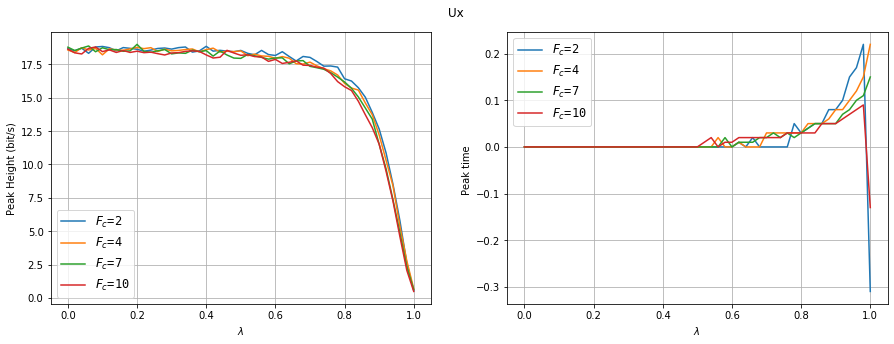

In [16]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(15, 5)
fig.suptitle('Ux',y =0.95)
legend = []
for i in range(len(annots_list)):
    legend.append(r'$F_c$='+str(Fc_list[i]))
    ax2.plot(Lambdas,Ux_peakH_list[i])
    ax2.set_xlabel(r'$\lambda $ ')
    ax2.set_ylabel(r'Peak Height (bit/s)')
    ax3.plot(Lambdas,Ux_peaktime_list[i])
    ax3.set_xlabel(r'$\lambda$ ')
    ax3.set_ylabel('Peak time ')
ax3.legend( legend, loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.legend( legend, loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
if XOsave:
    name = 'Ux_PeakHeightnTime'
    plt.gcf().savefig(save_folder+name+'.tif')

## Uv

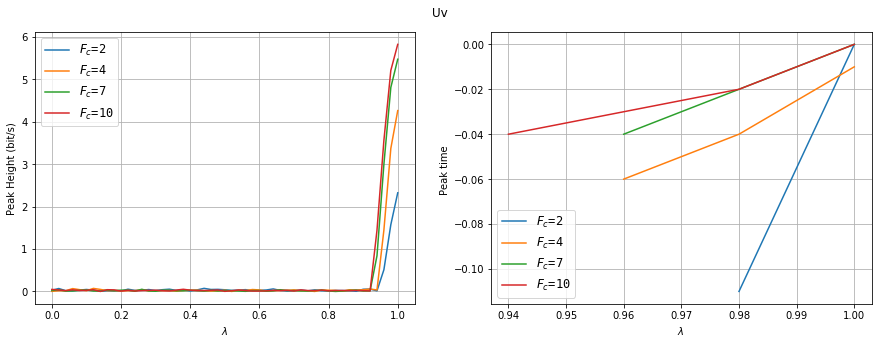

In [17]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(15, 5)
fig.suptitle('Uv',y =0.95)
legend = []
for i in range(len(annots_list)):
    legend.append(r'$F_c$='+str(Fc_list[i]))
    ax2.plot(Lambdas,Uv_peakH_list[i])
    ax2.set_xlabel(r'$\lambda $ ')
    ax2.set_ylabel(r'Peak Height (bit/s)')
    usefullI = np.where(Uv_peakH_list[i]>=1)
    ax3.plot(Lambdas[usefullI],Uv_peaktime_list[i][usefullI])
    ax3.set_xlabel(r'$\lambda$ ')
    ax3.set_ylabel('Peak time ')
ax3.legend( legend, loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.legend( legend, loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
if XOsave:
    name = 'Uv_PeakHeightnTime'
    plt.gcf().savefig(save_folder+name+'.tif')

## Synergy

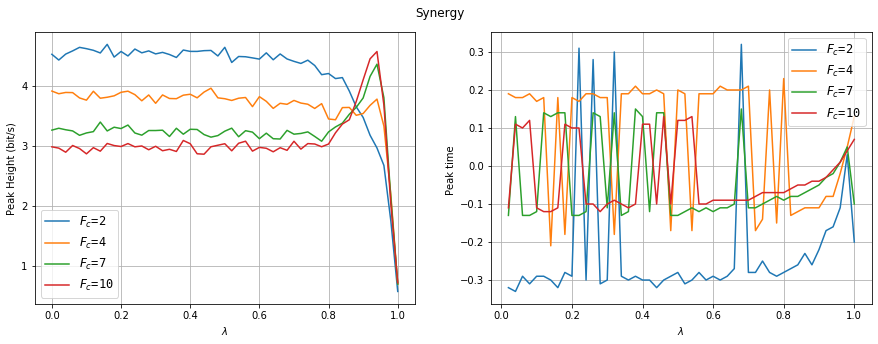

In [18]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(15, 5)
fig.suptitle('Synergy',y =0.95)
legend = []
for i in range(len(annots_list)):
    legend.append(r'$F_c$='+str(Fc_list[i]))
    ax2.plot(Lambdas,Syn_peakH_list[i])
    ax2.set_xlabel(r'$\lambda $ ')
    ax2.set_ylabel(r'Peak Height (bit/s)')
#     usefullI = np.where(Syn_peakH_list[i]>=1)
    ax3.plot(Lambdas[1:],Syn_peaktime_list[i][1:])
    ax3.set_xlabel(r'$\lambda$ ')
    ax3.set_ylabel('Peak time ')
ax3.legend( legend, loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.legend( legend, loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
if XOsave:
    name = 'Synergy_PeakHeightnTime'
    plt.gcf().savefig(save_folder+name+'.tif')

## Redundancy

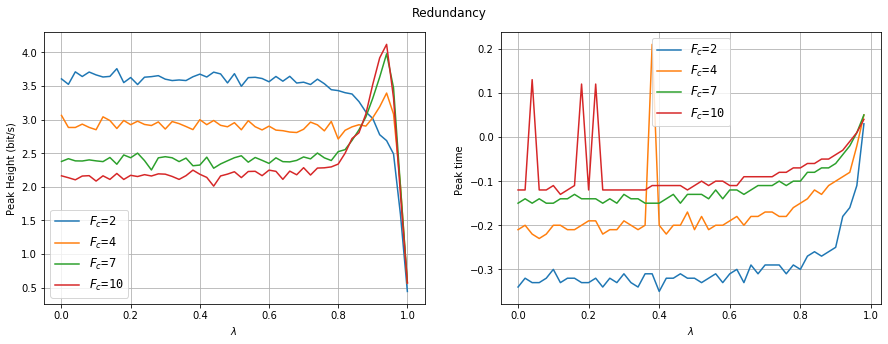

In [19]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(15, 5)
fig.suptitle('Redundancy',y =0.95)
legend = []
for i in range(len(annots_list)):
    legend.append(r'$F_c$='+str(Fc_list[i]))
    ax2.plot(Lambdas,Rdn_peakH_list[i])
    ax2.set_xlabel(r'$\lambda $ ')
    ax2.set_ylabel(r'Peak Height (bit/s)')
    usefullI = np.where(Rdn_peakH_list[i]>=1)
    ax3.plot(Lambdas[usefullI],Rdn_peaktime_list[i][usefullI])
    ax3.set_xlabel(r'$\lambda$ ')
    ax3.set_ylabel('Peak time ')
ax3.legend( legend, loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.legend( legend, loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
if XOsave:
    name = 'Redundancy_PeakHeightnTime'
    plt.gcf().savefig(save_folder+name+'.tif')

In [20]:
name = 'PeakHeightnTime vs Fc'
np.savez(save_folder+name+'.npz', Lambdas=Lambdas, Ux_peakH_list=Ux_peakH_list, Uv_peakH_list=Uv_peakH_list,
         Syn_peakH_list=Syn_peakH_list, Rdn_peakH_list=Rdn_peakH_list, Ux_peaktime_list=Ux_peaktime_list, 
         Uv_peaktime_list=Uv_peaktime_list, Syn_peaktime_list=Syn_peaktime_list, Rdn_peaktime_list=Rdn_peaktime_list,
         Fc_list=Fc_list)

In [ ]:
save_folder

In [ ]:
name